In [6]:
import pyspark
import xlrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-SQL-Solutions").getOrCreate()

## Read, clean and enrich the data

In [7]:
#Load the file through Pandas as Pyspark cannot read EXCEL files
sales_total_df = pd.read_excel('project_data_real_estate_toulouse_and_suburbs.xlsx', sheet_name='transactions',inferSchema='')
sales_total_df.head()

,SaleDate,SaleType,Price,PostCode,City,NbRooms,NbLots,ResidenceType,LivingArea,LandArea
0,2019-01-15,SALE,95000.0,31270,VILLENEUVE TOLOSANE,2,0,HOUSE,45,505
1,2019-01-21,SALE,261700.0,31270,VILLENEUVE TOLOSANE,4,0,HOUSE,87,311
2,2019-01-03,SALE,101000.0,31270,VILLENEUVE TOLOSANE,2,1,APARTMENT,44,0
3,2019-01-11,SALE,59500.0,31270,VILLENEUVE TOLOSANE,1,1,APARTMENT,26,0
4,2019-01-15,SALE,179000.0,31270,VILLENEUVE TOLOSANE,4,0,HOUSE,95,263


In [8]:
#Convert to spark data frame
sales_total_df = spark.createDataFrame(sales_total_df)

In [9]:
#Print Schema
sales_total_df.printSchema()

root
 |-- SaleDate: timestamp (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: long (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: long (nullable = true)
 |-- NbLots: long (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: long (nullable = true)
 |-- LandArea: long (nullable = true)



In [10]:
#Remove duplicate entries
sales_df = sales_total_df.distinct()
sales_df.show(5)

+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|           SaleDate|SaleType|   Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|2018-07-31 00:00:00|    SALE|194500.0|   31270|VILLENEUVE TOLOSANE|      3|     0|        HOUSE|        70|      65|
|2016-05-18 00:00:00|    SALE|145525.0|   31270|VILLENEUVE TOLOSANE|      4|     1|        HOUSE|        78|     159|
|2019-01-15 00:00:00|    SALE|550000.0|   31320|   VIEILLE TOULOUSE|      8|     0|        HOUSE|       211|    3006|
|2018-01-31 00:00:00|    SALE|118550.0|   31170|      TOURNEFEUILLE|      2|     1|    APARTMENT|        45|       0|
|2018-04-27 00:00:00|    SALE|116190.0|   31170|      TOURNEFEUILLE|      2|     1|    APARTMENT|        47|       0|
+-------------------+--------+--------+--------+--------

In [11]:
#Add a column RowId to be used in future analysis
sales_df=sales_df.withColumn("rowId", F.monotonically_increasing_id()) 

In [12]:
#Get Year and Month as separate columns to perform analysis based on Year and Month
split_col = pyspark.sql.functions.split(sales_df['SaleDate'], '-')
sales_df  = sales_df.withColumn('Year', split_col.getItem(0))
sales_df  = sales_df.withColumn('Month', split_col.getItem(1))
sales_df.show(5)

+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+-----+----+-----+
|           SaleDate|SaleType|   Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|rowId|Year|Month|
+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+-----+----+-----+
|2018-07-31 00:00:00|    SALE|194500.0|   31270|VILLENEUVE TOLOSANE|      3|     0|        HOUSE|        70|      65|    0|2018|   07|
|2016-05-18 00:00:00|    SALE|145525.0|   31270|VILLENEUVE TOLOSANE|      4|     1|        HOUSE|        78|     159|    1|2016|   05|
|2019-01-15 00:00:00|    SALE|550000.0|   31320|   VIEILLE TOULOUSE|      8|     0|        HOUSE|       211|    3006|    2|2019|   01|
|2018-01-31 00:00:00|    SALE|118550.0|   31170|      TOURNEFEUILLE|      2|     1|    APARTMENT|        45|       0|    3|2018|   01|
|2018-04-27 00:00:00|    SALE|116190.0|   31170|      T

In [13]:
#Create a view of the df to be used in SQL
sales_df.createOrReplaceTempView('sales')

In [14]:
#Count of sales
total_number_sales_df = spark.sql(" SELECT count(*) FROM sales ")

total_number_sales_df.show()

+--------+
|count(1)|
+--------+
|   71956|
+--------+



## I. Number of Properties Sold - General Analysis and Observations

### 1. Number of Properties sold  across years - House vs Apartment comparison

In [15]:
# Total number of sales grouped by City, Residence Type and year

total_number_ResidenceType_df = spark.sql(" SELECT Year,ResidenceType, count(*)  as Count FROM sales GROUP BY ResidenceType,Year \
                                  ORDER BY Year desc")

total_number_ResidenceType_df.show()


+----+-------------+-----+
|Year|ResidenceType|Count|
+----+-------------+-----+
|2019|    APARTMENT| 4028|
|2019|        HOUSE| 1157|
|2018|        HOUSE| 4110|
|2018|    APARTMENT|11516|
|2017|    APARTMENT|14437|
|2017|        HOUSE| 4291|
|2016|    APARTMENT|12690|
|2016|        HOUSE| 3681|
|2015|        HOUSE| 3593|
|2015|    APARTMENT|12453|
+----+-------------+-----+



In [16]:
#Convert to Pandas df to plot using seaborn
total_ResidenceType_pandas_df = total_number_ResidenceType_df.select("*").toPandas()

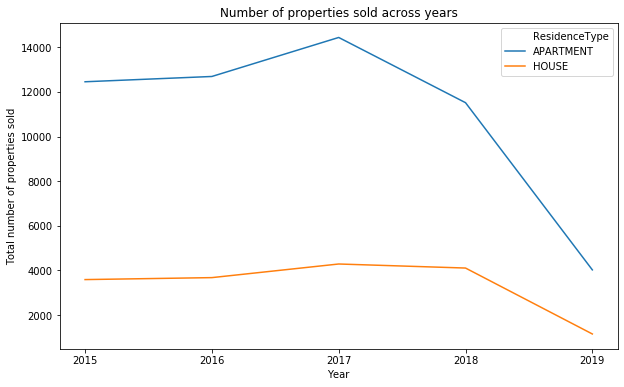

In [17]:
plt.figure( figsize = (10,6 ))
chart=sb.lineplot(data=total_ResidenceType_pandas_df, x='Year', hue='ResidenceType', y='Count', ci=None)
chart.set_title('Number of properties sold across years')
chart.set_xlabel('Year')
chart.set_ylabel('Total number of properties sold')
plt.show()

#### As anticipated, the number of Apartments sold is greated than the number of houses sold. 
#### A sharp climb is observed in 2017, in the number of Apartments sold.
#### Since 2018, the sales of both Apartments and Houses have been steadily declining

### 2. Number of Properties sold across years - City wise comparison

In [18]:
# Total number of sales grouped by City, Residence Type and year

total_number_City_df = spark.sql(" SELECT Year,City, count(*)  as Count FROM sales GROUP BY City,Year \
                                  ORDER BY Year desc")

total_number_City_df.show()


+----+-------------------+-----+
|Year|               City|Count|
+----+-------------------+-----+
|2019|         FENOUILLET|   42|
|2019|            L UNION|   80|
|2019| AUZEVILLE-TOLOSANE|    9|
|2019|   CASTANET TOLOSAN|   40|
|2019|              MURET|   26|
|2019|              BALMA|  105|
|2019|           LEGUEVIN|   43|
|2019| PLAISANCE DU TOUCH|   49|
|2019|            BLAGNAC|  117|
|2019|             LABEGE|    4|
|2019|         ESCALQUENS|   19|
|2019| PORTET SUR GARONNE|   30|
|2019|  QUINT-FONSEGRIVES|   31|
|2019|   VIEILLE TOULOUSE|    4|
|2019|            CUGNAUX|   87|
|2019|          COLOMIERS|  173|
|2019|VILLENEUVE TOLOSANE|   14|
|2019|      TOURNEFEUILLE|  104|
|2019|         AUCAMVILLE|   77|
|2019|       CORNEBARRIEU|   52|
+----+-------------------+-----+
only showing top 20 rows



In [19]:
#Convert to Pandas df to plot using seaborn
total_City_pandas_df = total_number_City_df.select("*").toPandas()

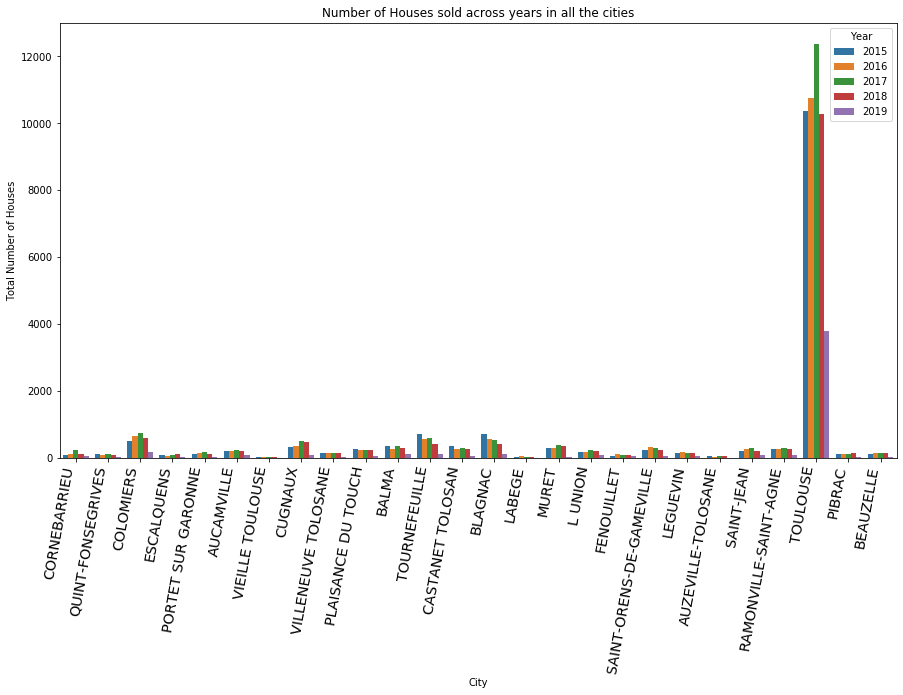

In [20]:
plt.figure( figsize = (15, 8) )
chart=sb.barplot(data=total_City_pandas_df, x='City', hue='Year', y='Count', ci=None)
chart.set_title('Number of Houses sold across years in all the cities')
chart.set_xlabel('City')
chart.set_ylabel('Total Number of Houses')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### Since Toulouse is a city and the remaining are suburbs it doesn't seem appropriate to include Toulouse in the analyis.

In [21]:
# Total number of sales grouped by City and year excluding Toulouse

total_City_edited_df = spark.sql("SELECT Year,City, count(*)  as Count FROM sales WHERE City!='TOULOUSE' GROUP BY City,Year \
                                  ORDER BY Year desc")

total_City_edited_df.show()


+----+-------------------+-----+
|Year|               City|Count|
+----+-------------------+-----+
|2019|         FENOUILLET|   42|
|2019|            L UNION|   80|
|2019|           LEGUEVIN|   43|
|2019|   CASTANET TOLOSAN|   40|
|2019|              MURET|   26|
|2019| AUZEVILLE-TOLOSANE|    9|
|2019| PORTET SUR GARONNE|   30|
|2019|         ESCALQUENS|   19|
|2019|              BALMA|  105|
|2019|            BLAGNAC|  117|
|2019|             LABEGE|    4|
|2019|       CORNEBARRIEU|   52|
|2019|      TOURNEFEUILLE|  104|
|2019|   VIEILLE TOULOUSE|    4|
|2019| PLAISANCE DU TOUCH|   49|
|2019|            CUGNAUX|   87|
|2019|          COLOMIERS|  173|
|2019|VILLENEUVE TOLOSANE|   14|
|2019|         AUCAMVILLE|   77|
|2019|  QUINT-FONSEGRIVES|   31|
+----+-------------------+-----+
only showing top 20 rows



In [22]:
#Convert to Pandas df to plot using seaborn
total_City_edited_pandas_df = total_City_edited_df.select("*").toPandas()

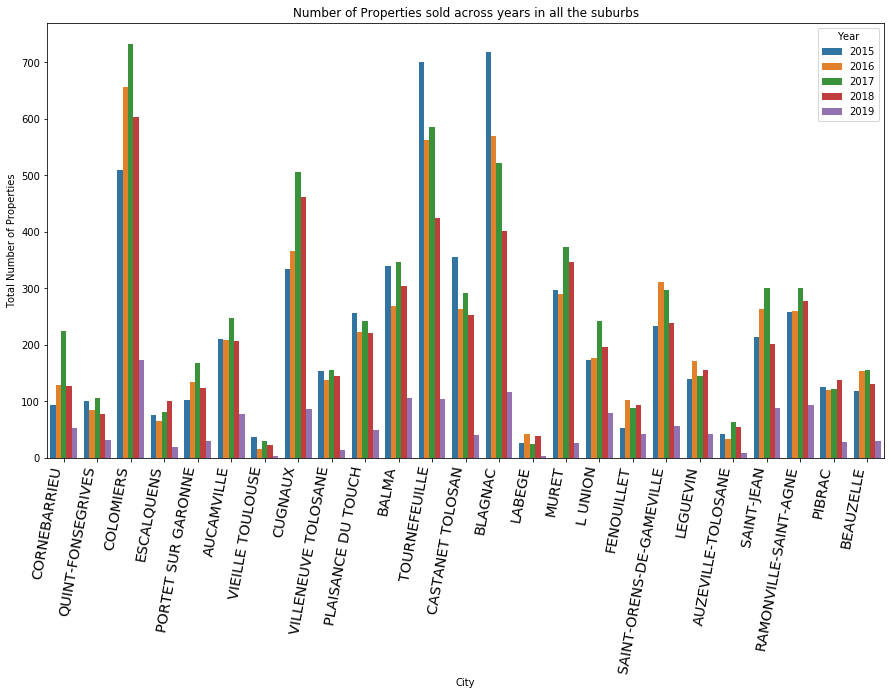

In [23]:
plt.figure( figsize = (15, 8) )
chart=sb.barplot(data=total_City_edited_pandas_df, x='City', hue='Year', y='Count', ci=None)
chart.set_title('Number of Properties sold across years in all the suburbs')
chart.set_xlabel('City')
chart.set_ylabel('Total Number of Properties')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### Colomiers had the most number of properties sold in 2017, with Blagnac and Tournefeuille coming a close secon in 2015. 

## II. Different Types of Sales - Analysis and Observation

### 1. Most Expensive Properties Sold

In [24]:
# Most expensive Properties 

Most_expensive_df = spark.sql(" SELECT max(Price) as MostExpensive,ResidenceType,City,Year FROM sales WHERE City!='TOULOUSE' GROUP BY ResidenceType,City,Year \
                                  ORDER BY MostExpensive,ResidenceType desc")

Most_expensive_df.show()

+-------------+-------------+-------------------+----+
|MostExpensive|ResidenceType|               City|Year|
+-------------+-------------+-------------------+----+
|     100000.0|    APARTMENT| PORTET SUR GARONNE|2019|
|    146106.12|    APARTMENT|VILLENEUVE TOLOSANE|2019|
|     162650.0|    APARTMENT|         FENOUILLET|2019|
|     168600.0|    APARTMENT| PLAISANCE DU TOUCH|2019|
|     170400.0|    APARTMENT|         ESCALQUENS|2019|
|     186000.0|    APARTMENT|           LEGUEVIN|2016|
|     187500.0|    APARTMENT|         FENOUILLET|2018|
|     195000.0|    APARTMENT|              MURET|2019|
|     215000.0|    APARTMENT|         ESCALQUENS|2015|
|     216000.0|    APARTMENT|             PIBRAC|2016|
|     225500.0|    APARTMENT|         ESCALQUENS|2017|
|     229900.0|    APARTMENT|       CORNEBARRIEU|2015|
|     230000.0|    APARTMENT|         FENOUILLET|2017|
|     231500.0|    APARTMENT| AUZEVILLE-TOLOSANE|2019|
|     238700.0|    APARTMENT|             PIBRAC|2018|
|     2390

In [25]:
#Convert to Pandas df to plot using seaborn
Most_exp_pandas_df = Most_expensive_df.select("*").toPandas()

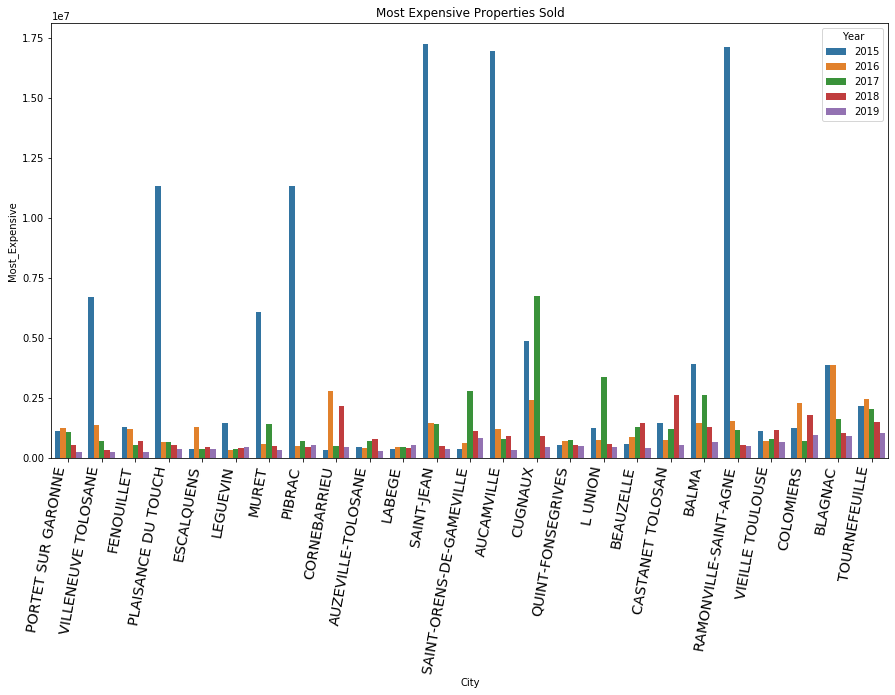

In [26]:
plt.figure( figsize = (15, 8) )
chart=sb.barplot(data=Most_exp_pandas_df, x='City', hue='Year', y='MostExpensive', ci=None)
chart.set_title('Most Expensive Properties Sold')
chart.set_xlabel('City')
chart.set_ylabel('Most_Expensive')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### The most expensive property was sold in 2015 in RAMONVILLE-SAINT-AGNE.
#### The year 2015 had the highest number of most expensive properties sold.

### 2. Sale Type - Exploration of Sale before Completion

In [27]:
# Sale Type analysis for suburbs

Sale_Type_df = spark.sql(" SELECT Year,SaleType,City,count(SaleType)as Count FROM sales WHERE City!='TOULOUSE' GROUP BY SaleType,City,Year \
                                  ORDER BY City desc")

Sale_Type_df.show()


+----+--------------------+-------------------+-----+
|Year|            SaleType|               City|Count|
+----+--------------------+-------------------+-----+
|2019|SALE BEFORE COMPL...|VILLENEUVE TOLOSANE|    1|
|2015|SALE BEFORE COMPL...|VILLENEUVE TOLOSANE|   31|
|2015|                SALE|VILLENEUVE TOLOSANE|  123|
|2017|SALE BEFORE COMPL...|VILLENEUVE TOLOSANE|   26|
|2016|                SALE|VILLENEUVE TOLOSANE|  112|
|2016|SALE BEFORE COMPL...|VILLENEUVE TOLOSANE|   25|
|2018|                SALE|VILLENEUVE TOLOSANE|  114|
|2017|                SALE|VILLENEUVE TOLOSANE|  130|
|2019|                SALE|VILLENEUVE TOLOSANE|   13|
|2018|SALE BEFORE COMPL...|VILLENEUVE TOLOSANE|   31|
|2019|                SALE|   VIEILLE TOULOUSE|    4|
|2015|                SALE|   VIEILLE TOULOUSE|   36|
|2018|                SALE|   VIEILLE TOULOUSE|   23|
|2016|                SALE|   VIEILLE TOULOUSE|   16|
|2017|                SALE|   VIEILLE TOULOUSE|   30|
|2018|SALE BEFORE COMPL...| 

In [28]:
#Convert to Pandas df to plot using seaborn
Sale_Type_pandas_df = Sale_Type_df.select("*").toPandas()

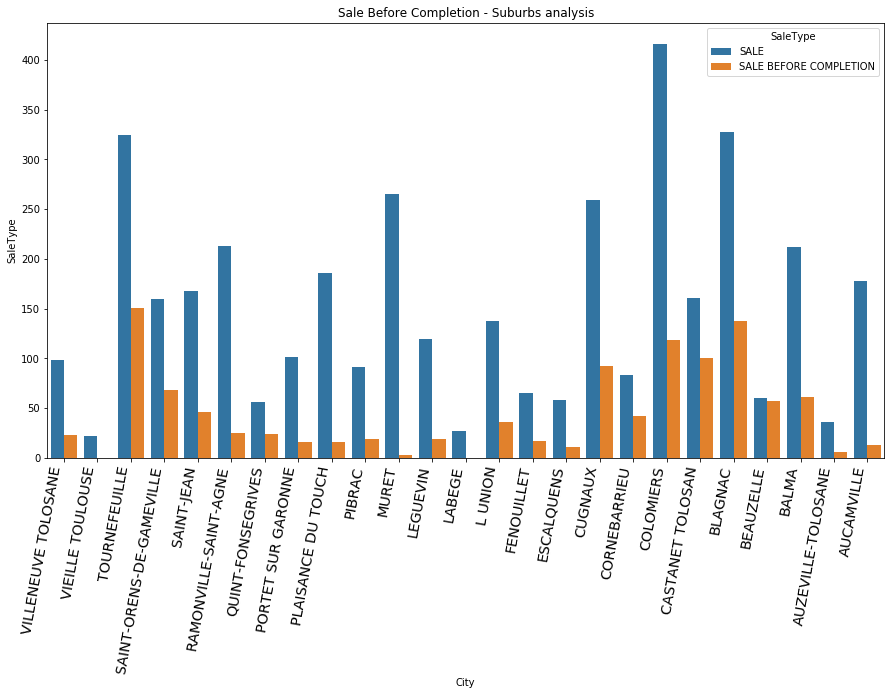

In [29]:
plt.figure( figsize = (15, 8) )
chart=sb.barplot(data=Sale_Type_pandas_df, x='City', hue='SaleType', y='Count', ci=None)
chart.set_title('Sale Before Completion - Suburbs analysis')
chart.set_xlabel('City')
chart.set_ylabel('SaleType')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### The suburbs like Tournefeuille, Blagnac, Colomiers, Castanet Tolosan have had sales before completion of construction indicating that these are hotspots and then next big investment after Toulouse as people were willing to pay to buy the property even before its completion.

#### This gives us an idea of the cities that are becoming the next big investment areas.

In [30]:
Before_completion_df = spark.sql(" SELECT Year,City,count(rowId)as Count FROM sales WHERE SaleType='SALE BEFORE COMPLETION' AND City!='TOULOUSE'\
                                  GROUP BY City,Year \
                                  ORDER BY City desc")

Before_completion_df.show()


+----+--------------------+-----+
|Year|                City|Count|
+----+--------------------+-----+
|2017| VILLENEUVE TOLOSANE|   26|
|2018| VILLENEUVE TOLOSANE|   31|
|2016| VILLENEUVE TOLOSANE|   25|
|2015| VILLENEUVE TOLOSANE|   31|
|2019| VILLENEUVE TOLOSANE|    1|
|2018|       TOURNEFEUILLE|   58|
|2016|       TOURNEFEUILLE|  194|
|2019|       TOURNEFEUILLE|    3|
|2015|       TOURNEFEUILLE|  323|
|2017|       TOURNEFEUILLE|  175|
|2018|SAINT-ORENS-DE-GA...|   27|
|2016|SAINT-ORENS-DE-GA...|  137|
|2017|SAINT-ORENS-DE-GA...|   89|
|2015|SAINT-ORENS-DE-GA...|   88|
|2019|SAINT-ORENS-DE-GA...|    1|
|2019|          SAINT-JEAN|    3|
|2015|          SAINT-JEAN|   26|
|2018|          SAINT-JEAN|   17|
|2016|          SAINT-JEAN|  110|
|2017|          SAINT-JEAN|   75|
+----+--------------------+-----+
only showing top 20 rows



In [31]:
#Convert to Pandas df to plot using seaborn
Before_completion_pandas_df = Before_completion_df.select("*").toPandas()

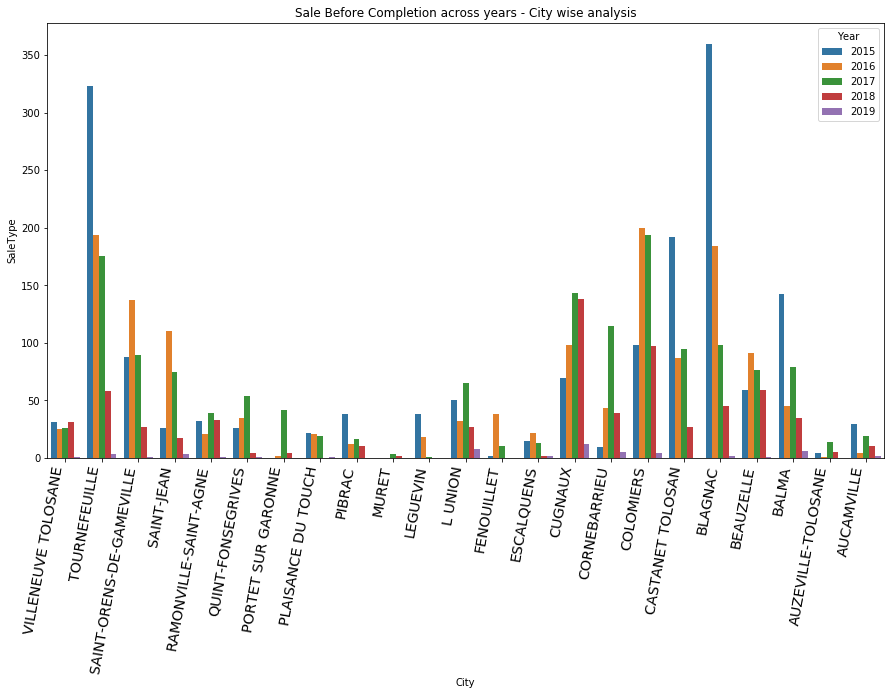

In [32]:
plt.figure( figsize = (15, 8) )
chart=sb.barplot(data=Before_completion_pandas_df, x='City', hue='Year', y='Count', ci=None)
chart.set_title('Sale Before Completion across years - City wise analysis')
chart.set_xlabel('City')
chart.set_ylabel('SaleType')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### On exploring the SALE BEFORE COMPLETION by years, we can understand that in 
#### 2015 - Blagnac 
#### 2016, 2017 - Colomiers
#### 2018, 2019 - Cugnaux

#### were the key investment areas

### 3. Sales outliers and range

In [33]:
#Keep only sales between 5 millions euros and  10k euros, as the remaining could be wrong entries
Price_range_df = spark.sql('SELECT * FROM sales WHERE Price BETWEEN 10000 AND 5000000')
Price_range_df.show()

+-------------------+--------------------+--------+--------+-------------------+-------+------+-------------+----------+--------+-----+----+-----+
|           SaleDate|            SaleType|   Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|rowId|Year|Month|
+-------------------+--------------------+--------+--------+-------------------+-------+------+-------------+----------+--------+-----+----+-----+
|2018-07-31 00:00:00|                SALE|194500.0|   31270|VILLENEUVE TOLOSANE|      3|     0|        HOUSE|        70|      65|    0|2018|   07|
|2016-05-18 00:00:00|                SALE|145525.0|   31270|VILLENEUVE TOLOSANE|      4|     1|        HOUSE|        78|     159|    1|2016|   05|
|2019-01-15 00:00:00|                SALE|550000.0|   31320|   VIEILLE TOULOUSE|      8|     0|        HOUSE|       211|    3006|    2|2019|   01|
|2018-01-31 00:00:00|                SALE|118550.0|   31170|      TOURNEFEUILLE|      2|     1|    APARTMENT|        4

In [34]:
# convert to pandas
Price_range_pandas_df = Price_range_df.select("*").toPandas()
Price_range_pandas_df['Price'] = Price_range_pandas_df['Price'].astype(float)

(0, 800000.0)

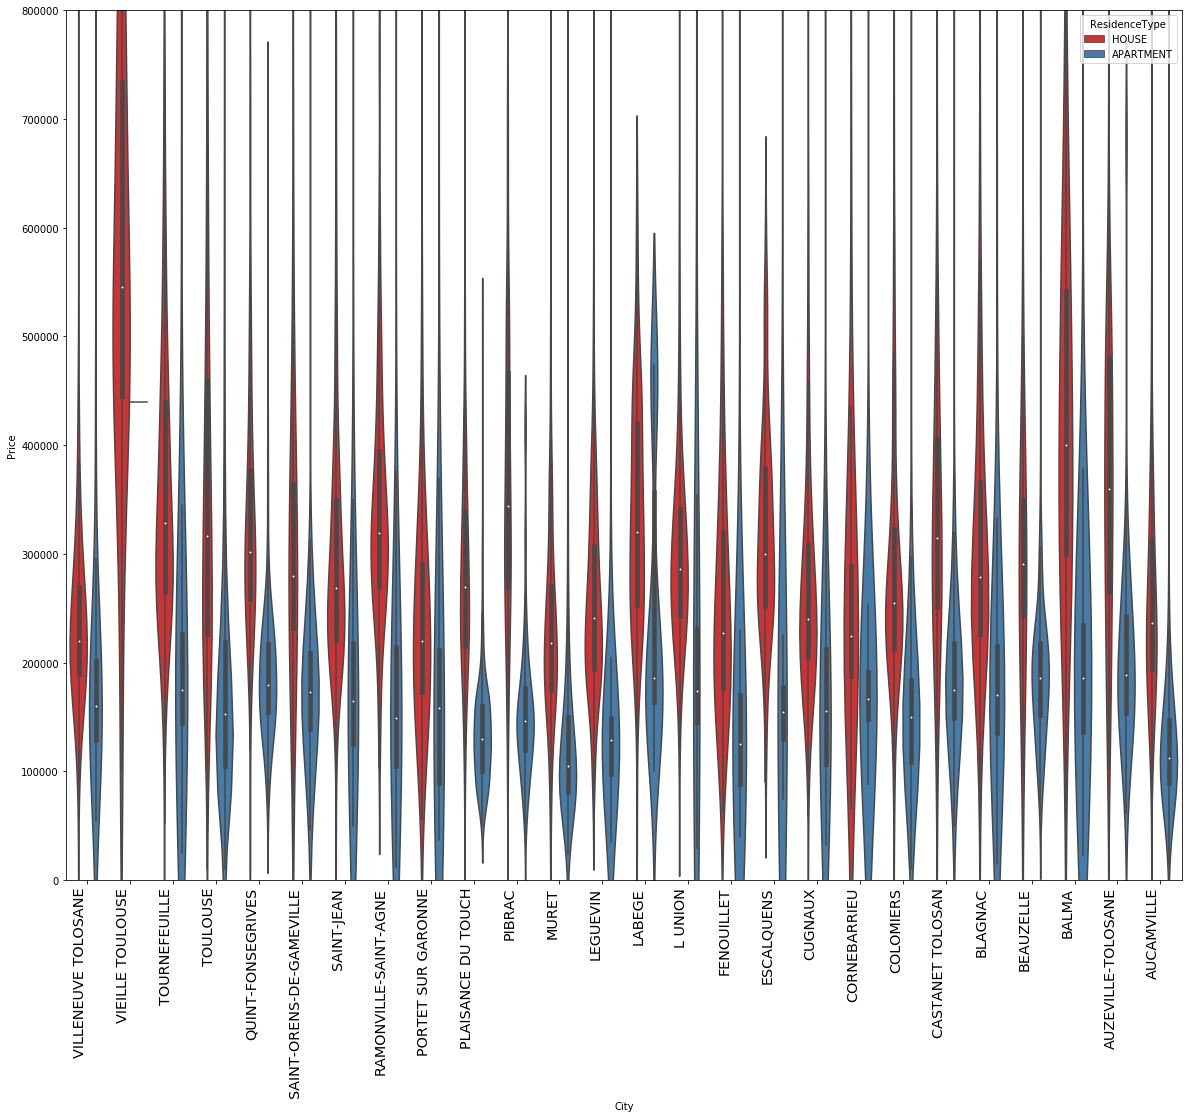

In [35]:
ax = plt.figure( figsize = (20, 16) )
chart=sb.violinplot(x="City", y="Price", hue="ResidenceType", data=Price_range_pandas_df, palette="Set1")
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='right',
                        fontweight='light',
                        fontsize='x-large',
                    )
plt.ylim(0, 0.8e6)

## III. Toulouse - Observations

### 1. Sale seasonality across months

In [36]:
Toulouse_df = spark.sql(" SELECT count(*) as HousesSold,Month,Year FROM sales WHERE City='TOULOUSE' GROUP BY Month,Year \
                                  ORDER BY Year,Month desc")
Toulouse_df.show()

+----------+-----+----+
|HousesSold|Month|Year|
+----------+-----+----+
|      1195|   12|2015|
|       766|   11|2015|
|       935|   10|2015|
|       977|   09|2015|
|       704|   08|2015|
|      1134|   07|2015|
|       933|   06|2015|
|       682|   05|2015|
|       882|   04|2015|
|       784|   03|2015|
|       745|   02|2015|
|       637|   01|2015|
|      1273|   12|2016|
|       878|   11|2016|
|       915|   10|2016|
|      1034|   09|2016|
|       885|   08|2016|
|      1106|   07|2016|
|      1029|   06|2016|
|       781|   05|2016|
+----------+-----+----+
only showing top 20 rows



In [37]:
#Convert to pandas df
Toulouse_pandas_df = Toulouse_df.select("*").toPandas()

In [38]:
Toulouse_pandas_df.Year = Toulouse_pandas_df.Year.astype(int)

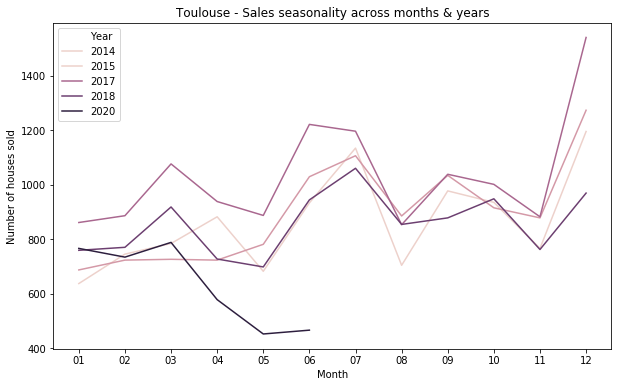

In [39]:
#Plot
plt.figure( figsize = (10,6))
chart=sb.lineplot(data=Toulouse_pandas_df, x='Month', hue='Year', y='HousesSold', ci=None)
chart.set_title('Toulouse - Sales seasonality across months & years')
chart.set_xlabel('Month')
chart.set_ylabel('Number of houses sold')
plt.show()

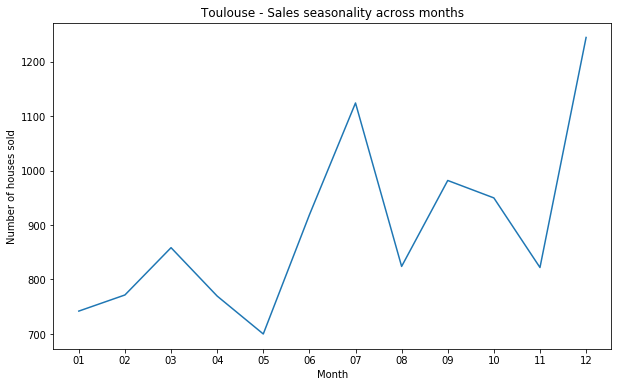

In [40]:
#Plot
plt.figure( figsize = (10,6))
chart=sb.lineplot(data=Toulouse_pandas_df, x='Month', y='HousesSold', ci=None)
chart.set_title('Toulouse - Sales seasonality across months')
chart.set_xlabel('Month')
chart.set_ylabel('Number of houses sold')
plt.show()

#### Sales in Toulouse peak during the months of July and December 

### 2. Property Comparison Toulouse Vs the Suburbs

In [41]:
Avg_per_city_Toulouse_df = spark.sql(" SELECT City,ResidenceType,Mean(Price) as Mean_Price,avg(NbRooms) as Avg_NbRooms,avg(LivingArea) as Avg_LivingArea, avg(LandArea) as Avg_LandArea FROM sales\
                            WHERE City='TOULOUSE'\
                             GROUP BY City,ResidenceType\
                             ORDER BY Mean_Price,Avg_NbRooms,Avg_LivingArea,Avg_LandArea")

Avg_per_city_Toulouse_df.show()


+--------+-------------+------------------+------------------+------------------+-----------------+
|    City|ResidenceType|        Mean_Price|       Avg_NbRooms|    Avg_LivingArea|     Avg_LandArea|
+--------+-------------+------------------+------------------+------------------+-----------------+
|TOULOUSE|    APARTMENT| 355390.9031401967|2.5549015824006176| 55.08799691238904|62.14352566576611|
|TOULOUSE|        HOUSE|435594.66332245426| 4.353133159268929|104.74934725848564|466.6964751958225|
+--------+-------------+------------------+------------------+------------------+-----------------+



In [42]:
Avg_per_city_Toulouse_df.createOrReplaceTempView('ToulouseAvg')

In [43]:
Avg_per_city_df = spark.sql(" SELECT 'Other Cities' as City, ResidenceType,Mean(Price) as Mean_Price,avg(NbRooms) as Avg_NbRooms,avg(LivingArea) as Avg_LivingArea, avg(LandArea) as Avg_LandArea FROM sales\
                            WHERE City!='TOULOUSE'\
                             GROUP BY ResidenceType\
                             ORDER BY Mean_Price,Avg_NbRooms,Avg_LivingArea,Avg_LandArea")

Avg_per_city_df.show()


+------------+-------------+------------------+------------------+------------------+-----------------+
|        City|ResidenceType|        Mean_Price|       Avg_NbRooms|    Avg_LivingArea|     Avg_LandArea|
+------------+-------------+------------------+------------------+------------------+-----------------+
|Other Cities|    APARTMENT|284633.68940298515|2.7083699151302314| 58.08750365817969|56.66542288557214|
|Other Cities|        HOUSE| 347610.7595356876| 4.537649476831091|109.19441330343797|610.0130792227205|
+------------+-------------+------------------+------------------+------------------+-----------------+



In [44]:
Avg_per_city_df.createOrReplaceTempView('OtherCitiesAvg')

In [45]:
Avg_union_df = Avg_per_city_Toulouse_df.unionByName(Avg_per_city_df)
Avg_union_df.show()

+------------+-------------+------------------+------------------+------------------+-----------------+
|        City|ResidenceType|        Mean_Price|       Avg_NbRooms|    Avg_LivingArea|     Avg_LandArea|
+------------+-------------+------------------+------------------+------------------+-----------------+
|    TOULOUSE|    APARTMENT| 355390.9031401967|2.5549015824006176| 55.08799691238904|62.14352566576611|
|    TOULOUSE|        HOUSE|435594.66332245426| 4.353133159268929|104.74934725848564|466.6964751958225|
|Other Cities|    APARTMENT|284633.68940298515|2.7083699151302314| 58.08750365817969|56.66542288557214|
|Other Cities|        HOUSE| 347610.7595356876| 4.537649476831091|109.19441330343797|610.0130792227205|
+------------+-------------+------------------+------------------+------------------+-----------------+



In [46]:
Avg_union_pandas_df = Avg_union_df.select("*").toPandas()

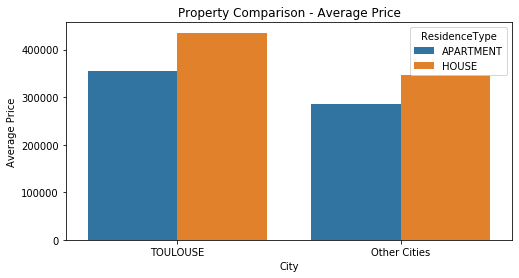

In [47]:
plt.figure( figsize = (8,4) )
chart=sb.barplot(data=Avg_union_pandas_df, x='City', hue='ResidenceType', y='Mean_Price', ci=None)
chart.set_title('Property Comparison - Average Price')
chart.set_xlabel('City')
chart.set_ylabel('Average Price')
plt.show()

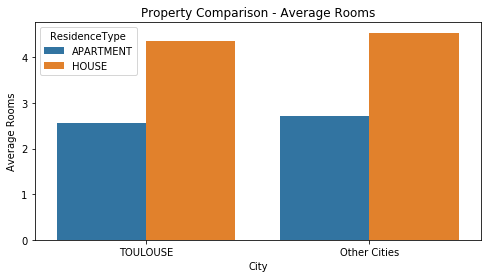

In [48]:
plt.figure( figsize = (8, 4) )
chart=sb.barplot(data=Avg_union_pandas_df, x='City', hue='ResidenceType', y='Avg_NbRooms', ci=None)
chart.set_title('Property Comparison - Average Rooms')
chart.set_xlabel('City')
chart.set_ylabel('Average Rooms')
plt.show()

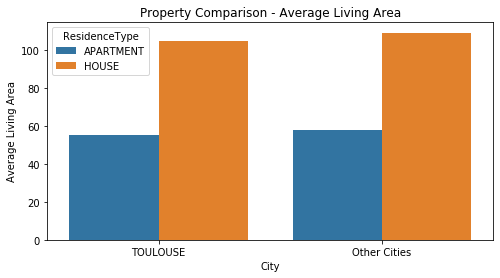

In [49]:
plt.figure( figsize = (8, 4) )
chart=sb.barplot(data=Avg_union_pandas_df, x='City', hue='ResidenceType', y='Avg_LivingArea', ci=None)
chart.set_title('Property Comparison - Average Living Area')
chart.set_xlabel('City')
chart.set_ylabel('Average Living Area')
plt.show()

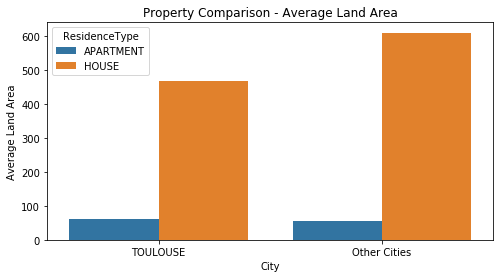

In [50]:
plt.figure( figsize = (8, 4) )
chart=sb.barplot(data=Avg_union_pandas_df, x='City', hue='ResidenceType', y='Avg_LandArea', ci=None)
chart.set_title('Property Comparison - Average Land Area')
chart.set_xlabel('City')
chart.set_ylabel('Average Land Area')
plt.show()

#### There are no stark contrast in the properties within and outside Toulouse. As anticipated :  
####  - the Apartments and Houses in Toulouse cost higher than the ones in the Suburbs
####  - the land area of the Houses in Toulouse is lesser than the ones in the Suburbs

## IV. Price Evolution

In [51]:
Evolution_df = spark.sql(" SELECT City,Year,sum(Price)/sum(LivingArea) as Price_Per_Unit FROM sales\
                             GROUP BY City,Year\
                             ORDER BY City,Year")

Evolution_df.show()


+------------------+----+------------------+
|              City|Year|    Price_Per_Unit|
+------------------+----+------------------+
|        AUCAMVILLE|2015|12155.557809988519|
|        AUCAMVILLE|2016|2801.8018388877244|
|        AUCAMVILLE|2017| 2539.511617742602|
|        AUCAMVILLE|2018|2869.0615276804483|
|        AUCAMVILLE|2019| 2457.284268914151|
|AUZEVILLE-TOLOSANE|2015| 2737.233401889939|
|AUZEVILLE-TOLOSANE|2016| 2487.403933033483|
|AUZEVILLE-TOLOSANE|2017|3345.8442854584523|
|AUZEVILLE-TOLOSANE|2018| 3252.564034657512|
|AUZEVILLE-TOLOSANE|2019| 2363.012457531144|
|             BALMA|2015|5604.0307898745195|
|             BALMA|2016| 3489.074055822755|
|             BALMA|2017| 3514.664282319392|
|             BALMA|2018| 3354.533372116349|
|             BALMA|2019| 3239.181714844599|
|         BEAUZELLE|2015|3074.4890862351017|
|         BEAUZELLE|2016|3271.2885495054084|
|         BEAUZELLE|2017| 3748.872243346007|
|         BEAUZELLE|2018| 3255.999965972778|
|         

In [52]:
#Convert to pandas df
Evolution_pandas_df = Evolution_df.select("*").toPandas()

In [53]:
Evolution_pandas_df['Evolution']=100*Evolution_pandas_df['Price_Per_Unit'].diff()/Evolution_pandas_df['Price_Per_Unit']
Evolution_pandas_df

,City,Year,Price_Per_Unit,Evolution
0,AUCAMVILLE,2015,12155.557810,NaN
1,AUCAMVILLE,2016,2801.801839,-333.847878
2,AUCAMVILLE,2017,2539.511618,-10.328373
3,AUCAMVILLE,2018,2869.061528,11.486331
4,AUCAMVILLE,2019,2457.284269,-16.757412
...,...,...,...,...
125,VILLENEUVE TOLOSANE,2015,5429.394722,39.041549
126,VILLENEUVE TOLOSANE,2016,3338.112757,-62.648632
127,VILLENEUVE TOLOSANE,2017,2947.477359,-13.253211
128,VILLENEUVE TOLOSANE,2018,2545.086133,-15.810515


In [54]:
Evolution_pandas_df = Evolution_pandas_df[Evolution_pandas_df.Year!='2015']
Evolution_pandas_df

,City,Year,Price_Per_Unit,Evolution
1,AUCAMVILLE,2016,2801.801839,-333.847878
2,AUCAMVILLE,2017,2539.511618,-10.328373
3,AUCAMVILLE,2018,2869.061528,11.486331
4,AUCAMVILLE,2019,2457.284269,-16.757412
6,AUZEVILLE-TOLOSANE,2016,2487.403933,-10.043784
...,...,...,...,...
124,VIEILLE TOULOUSE,2019,3309.674923,-3.036193
126,VILLENEUVE TOLOSANE,2016,3338.112757,-62.648632
127,VILLENEUVE TOLOSANE,2017,2947.477359,-13.253211
128,VILLENEUVE TOLOSANE,2018,2545.086133,-15.810515


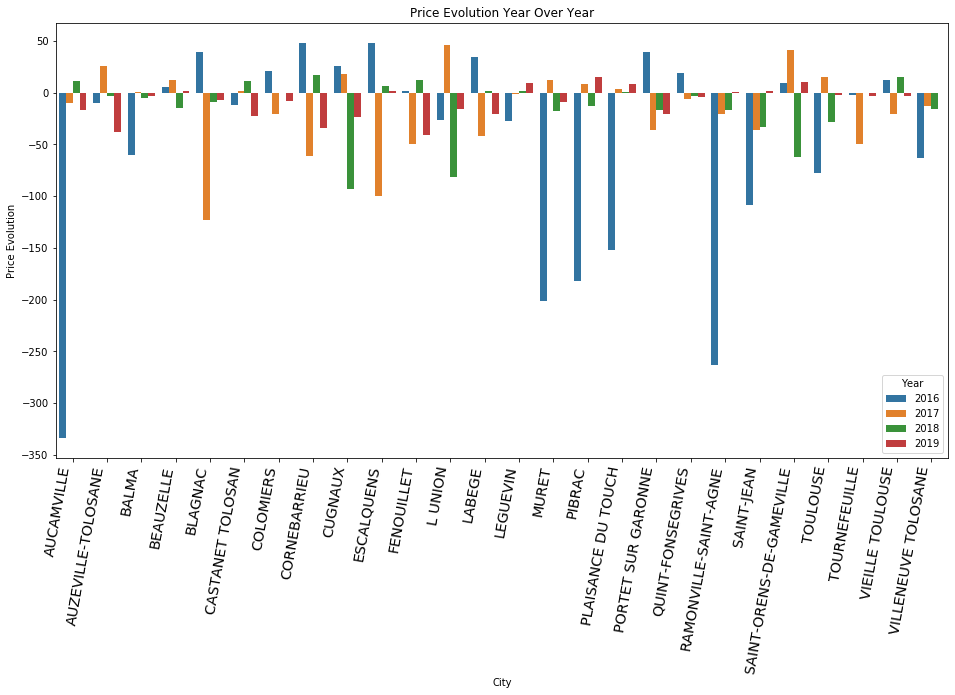

In [55]:
plt.figure( figsize = (16, 8) )
chart=sb.barplot(data=Evolution_pandas_df, x='City', hue='Year', y='Evolution', ci=None)
chart.set_title('Price Evolution Year Over Year')
chart.set_xlabel('City')
chart.set_ylabel('Price Evolution')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    ) 
plt.show()

#### Price evolution in each city cannot be standardised. Though there seems to be significant dip in Prices in 2016